In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import pandas as pd
import os 
import PIL
import time

## Load Data

### Load Dataset

In [46]:
dataset_name = 'diabetic_retinopathy_detection/btgraham-300'
subdataset_name = 'btgraham-300'
print(dataset_name)

diabetic_retinopathy_detection/btgraham-300


In [47]:
#dataset, info= tfds.load(dataset_name,split=tfds.Split.TRAIN, download=True, with_info=True)
dataset, info = tfds.load(dataset_name,split=['train', 'test'], download=True, with_info=True)
#dataset = dataset.map(lambda image: tf.image.resize_with_crop_or_pad(image, 64, 64))
print(type(dataset))

<class 'list'>


### Load Models

In [48]:
def make_discriminator_model():
  aKernelSize = 5
  aStrides = 2
  dropOutRatio = 0.3

  layersInfo = [(32, 64), (16,128), (8, 256), (4, 512)]
  
  model = tf.keras.Sequential()
  
  layer_0 = layersInfo[0]
  model.add(layers.Conv2D(layer_0[1], kernel_size=aKernelSize, strides=aStrides, padding='same', input_shape=[64, 64, 3], name='dis_1'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_1 = layersInfo[1]
  model.add(layers.Conv2D(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_2'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_2 = layersInfo[2]
  model.add(layers.Conv2D(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_3'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_3 = layersInfo[3]
  model.add(layers.Conv2D(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_4'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  model.add(layers.Flatten())
  model.add(layers.Dense(1)
)

  return model

In [49]:
def make_generator_model():
  aKernelSize = 5
  aStrides = 2
  z_dim = 100

  layersInfo = [(4, 1024), (8, 512), (16,256), (32, 128), (64, 3)]
  
  layer_0 = (4, 1024)
  model = tf.keras.Sequential()
  model.add(layers.Dense(layer_0[0] ** 2 * layer_0[1], use_bias=False, input_shape=(z_dim,), name='gen_1'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  
  model.add(layers.Reshape((layer_0[0], layer_0[0], layer_0[1])))
  print(model.output_shape)
  assert model.output_shape == (None, layer_0[0], layer_0[0], layer_0[1])  # Note: None is the batch size

  layer_1 = layersInfo[1]
  model.add(layers.Conv2DTranspose(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_2'))
  print(model.output_shape)
  assert model.output_shape == (None, layer_1[0], layer_1[0], layer_1[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_2 = layersInfo[2]
  model.add(layers.Conv2DTranspose(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_3'))
  assert model.output_shape == (None, layer_2[0], layer_2[0], layer_2[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_3 = layersInfo[3]
  model.add(layers.Conv2DTranspose(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_4'))
  assert model.output_shape == (None, layer_3[0], layer_3[0], layer_3[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_4 = layersInfo[4]
  model.add(layers.Conv2DTranspose(layer_4[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, activation='tanh', name='gen_5'))
  assert model.output_shape == (None, layer_4[0], layer_4[0], layer_4[1])

  return model

In [50]:
generator = make_generator_model()

(None, 4, 4, 1024)
(None, 8, 8, 512)


In [51]:
discriminator = make_discriminator_model()

In [52]:
learing_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(learing_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learing_rate)

### Create Checkpoint Variable

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Restore GAN Trained Data

From the last checkpoint, restore all the variables data

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Check what gan trained

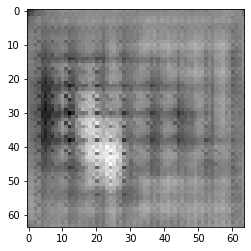

In [55]:
seed = tf.random.normal([16, 100])
generatedImage = generator(seed, training=False)
_ = plt.imshow(generatedImage[0, :, :, 0], cmap='gray')

## Prepare Dataset

For preparing the dataset, first we need to extract the features from the Gan Discriminator. 

Once we have the features we need to reshape the images to the input size of the discriminator and save the output of each image from the flatten discriminator.

### Extract features from discriminator

In [56]:
discriminator_flatten = tf.keras.models.clone_model(discriminator)
discriminator_flatten.set_weights(discriminator.get_weights())
discriminator_flatten.pop()
discriminator_flatten.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dis_1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
dis_2 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
dis_3 (Conv2D)               (None, 8, 8, 256)        

### Reshape and evaluation of the discriminator

In this step we split the data in image and label. With the image we reshape the image, then apply to the feature function. Return the dataset

In [57]:
IMG_SIZE = 64

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [101]:

AUTOTUNE = tf.data.AUTOTUNE

def reshapeDataset(ds):
  # Resize and rescale all datasets.
  ds_image = ds.map(lambda x: ({'x': resize_and_rescale(x['image']), 'y': x['label']} ), 
              num_parallel_calls=AUTOTUNE)
  
  ds_label = ds.map(lambda x: x['label'], num_parallel_calls=AUTOTUNE) 
  return ds_image.prefetch(buffer_size=AUTOTUNE).batch(1).map(lambda t: discriminator_flatten(t['x'], training=False)[0]), ds_label.prefetch(buffer_size=AUTOTUNE)

### Get the train and test, data and labels

In [102]:
reshape_train_data, reshape_train_label = reshapeDataset(dataset[0])
reshape_test_data, reshape_test_label = reshapeDataset(dataset[1])

### Transform to Numpy Arrays

As the LinearRegression model in tensorflow is experimental and the tensors are difficult to manage, we transform both tensors to numpys

In [103]:
def dataset_len (ds):
  num_elements = 0
  for elem in ds:
    num_elements += 1
  return num_elements

In [66]:
count = 9
len = 10
print( str(count) + "/" + str(len) + " , (" +  str(count * 100/len) + "%)")

9/10 , (90.0%)


In [131]:
def tensor_data_to_np (tensor, input_size=8192, verbose=False, name="Data"):
  data_array = np.empty((0, input_size), int)
  if verbose:
    print('Counting dataset len')
  total_len = dataset_len(tensor)
  count = 0
  for x in tensor:
    count = count + 1
    data_array = np.append(data_array, [tfds.as_numpy(x)], axis=0)
    if verbose:
      print(name + ": "+ str(count) + "/" + str(total_len) + " , (" +  str(count * 100/total_len) + "%)")
  return data_array
    

In [132]:
def tensor_label_to_np(tensor, verbose=False, name="Label"):
  data_array = np.array([])
  if verbose:
    print('Counting dataset len')
  total_len = dataset_len(tensor)
  count = 0
  for x in tensor:
    count = count + 1
    data_array = np.append(data_array, tfds.as_numpy(x))
    if verbose:
      print(name + ": "+ str(count) + "/" + str(total_len) + " , (" +  str(count * 100/total_len) + "%)")
  return data_array
    

In [133]:
train_x = tensor_data_to_np(reshape_train_data, verbose=True)
train_y = tensor_label_to_np(reshape_train_label, verbose=True)


Counting dataset len
Data: 1/35126 , (0.002846894038603883%)
Data: 2/35126 , (0.005693788077207766%)
Data: 3/35126 , (0.00854068211581165%)
Data: 4/35126 , (0.011387576154415532%)
Data: 5/35126 , (0.014234470193019415%)
Data: 6/35126 , (0.0170813642316233%)
Data: 7/35126 , (0.01992825827022718%)
Data: 8/35126 , (0.022775152308831065%)
Data: 9/35126 , (0.025622046347434948%)
Data: 10/35126 , (0.02846894038603883%)
Data: 11/35126 , (0.03131583442464272%)
Data: 12/35126 , (0.0341627284632466%)
Data: 13/35126 , (0.037009622501850484%)
Data: 14/35126 , (0.03985651654045436%)
Data: 15/35126 , (0.04270341057905825%)
Data: 16/35126 , (0.04555030461766213%)
Data: 17/35126 , (0.048397198656266016%)
Data: 18/35126 , (0.051244092694869896%)
Data: 19/35126 , (0.05409098673347378%)
Data: 20/35126 , (0.05693788077207766%)
Data: 21/35126 , (0.05978477481068155%)
Data: 22/35126 , (0.06263166884928544%)
Data: 23/35126 , (0.06547856288788931%)
Data: 24/35126 , (0.0683254569264932%)
Data: 25/35126 , (0.07

In [155]:
test_x = tensor_data_to_np(reshape_test_data, verbose=True)
test_y = tensor_label_to_np(reshape_test_label, verbose=True)


Counting dataset len
Data: 1/42670 , (0.002343566908835247%)
Data: 2/42670 , (0.004687133817670494%)
Data: 3/42670 , (0.007030700726505742%)
Data: 4/42670 , (0.009374267635340989%)
Data: 5/42670 , (0.011717834544176237%)
Data: 6/42670 , (0.014061401453011484%)
Data: 7/42670 , (0.016404968361846732%)
Data: 8/42670 , (0.018748535270681977%)
Data: 9/42670 , (0.021092102179517225%)
Data: 10/42670 , (0.023435669088352474%)
Data: 11/42670 , (0.02577923599718772%)
Data: 12/42670 , (0.028122802906022967%)
Data: 13/42670 , (0.030466369814858216%)
Data: 14/42670 , (0.032809936723693464%)
Data: 15/42670 , (0.035153503632528706%)
Data: 16/42670 , (0.037497070541363954%)
Data: 17/42670 , (0.0398406374501992%)
Data: 18/42670 , (0.04218420435903445%)
Data: 19/42670 , (0.0445277712678697%)
Data: 20/42670 , (0.04687133817670495%)
Data: 21/42670 , (0.04921490508554019%)
Data: 22/42670 , (0.05155847199437544%)
Data: 23/42670 , (0.053902038903210686%)
Data: 24/42670 , (0.056245605812045935%)
Data: 25/4267

#### Save arrays if are necessary

In [138]:
np.save('train_data.csv', train_x)
np.save('train_label.csv', train_y)

In [ ]:
train_x = np.load('train_data.csv')
train_y = np.load('train_label.csv')

In [156]:
np.save('test_data', test_x)
np.save('test_label', test_y)

In [ ]:
test_x = np.load('test_data')
test_y = np.load('test_label')

In [147]:
train_x.shape

(35126, 8192)

In [148]:
train_y.shape

(35126,)

## Prepare Linear regression model

- Build model
- Instanciate model 

In [143]:
def build_linear_regression_model (optimizerProp=0.001):
  """model = tf.keras.Sequential()
  model.add(layers.Dense(1, input_dim=input_shape, activation='linear'))
  
  model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mse'])
  return model"""
  linear_model = tf.keras.experimental.LinearModel()
  linear_model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(optimizerProp), metrics=['mae', 'mse','accuracy'])
  return linear_model
  # loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse']
  # history = linear_model.fit(x_data, y_data, epochs=1000)
  # linear_model.metrics_names
  

In [144]:
model = build_linear_regression_model()



## Train & Test Model

In [146]:
history = model.fit(train_x, train_y, epochs=100)

Epoch 1/100
1098/1098 [==============================] - 1s 926us/step - loss: 3.7906 - mae: 1.6387 - mse: 3.7906 - accuracy: 0.4009
Epoch 2/100
1098/1098 [==============================] - 1s 908us/step - loss: 3.7670 - mae: 1.6235 - mse: 3.7670 - accuracy: 0.4014
Epoch 3/100
1098/1098 [==============================] - 1s 934us/step - loss: 3.7730 - mae: 1.6350 - mse: 3.7730 - accuracy: 0.4022
Epoch 4/100
1098/1098 [==============================] - 1s 938us/step - loss: 3.8028 - mae: 1.6491 - mse: 3.8028 - accuracy: 0.4037
Epoch 5/100
1098/1098 [==============================] - 1s 953us/step - loss: 3.7902 - mae: 1.6473 - mse: 3.7902 - accuracy: 0.4012
Epoch 6/100
1098/1098 [==============================] - 1s 960us/step - loss: 3.7965 - mae: 1.6495 - mse: 3.7965 - accuracy: 0.4018
Epoch 7/100
1098/1098 [==============================] - 1s 993us/step - loss: 3.8053 - mae: 1.6596 - mse: 3.8053 - accuracy: 0.4009
Epoch 8/100
1098/1098 [==============================] - 1s 1ms/step 

### Show train stadistics

In [151]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  #plt.figure()
  #plt.xlabel('Epoch')
  #plt.ylabel('Mean Square Error [$MPG^2$]')
  #plt.plot(hist['epoch'], hist['mse'],
  #         label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mse'],
  #         label = 'Val Error')
  #plt.ylim([0,20])
  #plt.legend()
  #plt.show()

KeyError: 'val_mae'

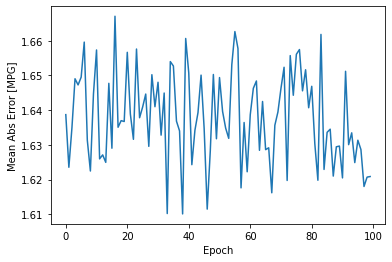

In [152]:
plot_history(history)

### Test model

Test with the trained data

In [153]:
model.evaluate(train_x, train_y)

1098/1098 [==============================] - 1s 766us/step - loss: 3.8349 - mae: 1.7064 - mse: 3.8349 - accuracy: 0.7348


[3.83485746383667, 1.706404209136963, 3.83485746383667, 0.7347833514213562]

test with the test data

In [157]:
model.evaluate(test_x, test_y)

1334/1334 [==============================] - 1s 636us/step - loss: 3.8669 - mae: 1.7073 - mse: 3.8669 - accuracy: 0.7360


[3.8669095039367676, 1.707343578338623, 3.8669095039367676, 0.7359502911567688]

### What if...???
Instead of 5 classes, we have only 2...

In [164]:
def transform_label (npArr):
  new_train_y = np.array([])
  for x in npArr:
    new_val = 1 if x > 0 else 0
    new_train_y = np.append(new_train_y, new_val)
  return new_train_y

In [165]:
new_train_y = transform_label(train_y)

In [166]:
count = 0
for p in new_train_y:
  count = 1 + count
  if count < 10:
    print(p)

0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0


In [167]:
count = 0
for p in train_y:
  count = 1 + count
  if count < 10:
    print(p)

0.0
0.0
1.0
0.0
3.0
0.0
0.0
4.0
0.0


In [168]:
binaryClassModel = build_linear_regression_model()

In [173]:
binaryHistory = binaryClassModel.fit(train_x, new_train_y,epochs=100)

Epoch 1/100
1098/1098 [==============================] - 1s 1ms/step - loss: 3.1140 - mae: 1.6748 - mse: 3.1140 - accuracy: 0.4966
Epoch 2/100
1098/1098 [==============================] - 1s 1ms/step - loss: 3.1044 - mae: 1.6803 - mse: 3.1044 - accuracy: 0.4973
Epoch 3/100
1098/1098 [==============================] - 1s 936us/step - loss: 3.1155 - mae: 1.6757 - mse: 3.1155 - accuracy: 0.4978
Epoch 4/100
1098/1098 [==============================] - 1s 850us/step - loss: 3.1056 - mae: 1.6694 - mse: 3.1056 - accuracy: 0.4964
Epoch 5/100
1098/1098 [==============================] - 1s 825us/step - loss: 3.1080 - mae: 1.6679 - mse: 3.1080 - accuracy: 0.4999
Epoch 6/100
1098/1098 [==============================] - 1s 840us/step - loss: 3.0844 - mae: 1.6589 - mse: 3.0844 - accuracy: 0.5047
Epoch 7/100
1098/1098 [==============================] - 1s 842us/step - loss: 3.1024 - mae: 1.6668 - mse: 3.1024 - accuracy: 0.4995
Epoch 8/100
1098/1098 [==============================] - 1s 888us/step - 

In [170]:
new_test_y = transform_label(test_y)

In [174]:
binaryClassModel.evaluate(train_x, new_train_y)

1098/1098 [==============================] - 1s 998us/step - loss: 3.0077 - mae: 1.6768 - mse: 3.0077 - accuracy: 0.2652


[3.0076684951782227,
 1.6768077611923218,
 3.0076684951782227,
 0.2652166485786438]

In [175]:
binaryClassModel.evaluate(test_x, new_test_y)

1334/1334 [==============================] - 1s 979us/step - loss: 3.0109 - mae: 1.6764 - mse: 3.0109 - accuracy: 0.2640


[3.0109074115753174,
 1.6763818264007568,
 3.0109074115753174,
 0.2640496790409088]

KeyError: 'val_mae'

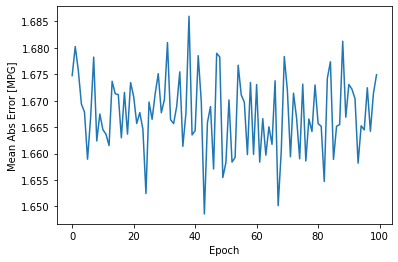

In [176]:
plot_history(binaryHistory)